In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import sklearn
import pandas as pd
import scipy.stats as stats

In [2]:
neuron_data = {}



In [3]:
files = sorted(os.listdir('../neuron_logs/train_data'))

In [ ]:
with open(os.path.join('..', 'neuron_logs', 'train_data', 'output_20191013-181903.json'), 'r') as f:
    neuron_data = json.load(f)

0.9909132719039917


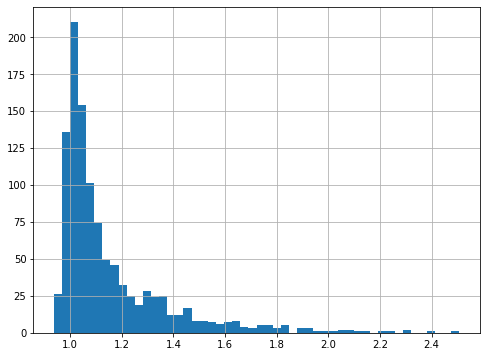

In [5]:
target = 'usefulness_loss'


target_thr = [neuron_data[e][neuron][target] for neuron in neuron_data['0'] for e in neuron_data  if e != '0' and ' ' in neuron and int(e) < 10]

threshold = np.percentile(target_thr, 10) 

print(threshold)

plt.figure(figsize = (8, 6), facecolor = 'w')
plt.hist(target_thr, bins = 50)
plt.grid()

In [171]:
print(neuron_data['1']['0 0'].keys())
np.array(neuron_data['1']['3 0']['output_weights']).shape

dict_keys(['activations', 'usefulness_loss', 'usefulness_acc', 'depth', 'inverse_depth', 'width', 'input_weights', 'output_weights', 'reg_loss_in_layer'])


(10,)

In [15]:
def reduce_to_statistics(activations, labels, debug=False):
    sorted_data = []
    for i in range(10): #hardcoded MOFO
        sorted_data += [[]]
    for i, a in zip(labels, activations):
        sorted_data[i] += [a]
    if debug:
        return(sorted_data)
    statistics = []
    for ar in sorted_data:
        curr_stats = stats.describe(ar)
        statistics += [curr_stats.mean, curr_stats.variance, curr_stats.skewness, curr_stats.kurtosis, curr_stats.minmax[0],
                       curr_stats.minmax[1], curr_stats.nobs]
        #print(statistics)
    return(statistics)

In [6]:
train, test = [], []
fin = 10
for i, filename in enumerate(files[:2]):
    with open(os.path.join('..', 'neuron_logs', 'train_data', filename), 'r') as f:
        print(filename)
        neuron_data = json.load(f)
    if i == 10:
        break
    for e in neuron_data.keys():
        if e == '0' or int(e) > fin:
            #print(e)
            continue
        for neuron in neuron_data[e]:
            if ' ' not in neuron:
                continue
            current_data = neuron_data[e][neuron]
            important_features = []
            #important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
            important_features = current_data['activations'][:2000]
            important_features += [current_data['depth']]
            important_features += [current_data['inverse_depth']]
            important_features += [current_data['width']]
            # important_features += [current_data['input_weights']]
            # important_features += [current_data['output_weights']]
            important_features += [current_data['reg_loss_in_layer']]
            train += [important_features]
            test += [int(current_data[target] > threshold)]

output_20191013-181903.json
output_20191013-185216.json


In [7]:
train = np.array(train)
test = np.array(test)

In [8]:
print(train.shape, test.shape)

(2400, 2004) (2400,)


In [9]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=0)
print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
clf = LogisticRegression(solver='liblinear', max_iter = 500).fit(X_train, y_train)
clf.score(X_test, y_test)

(1920, 2004) (480, 2004) (1920,) (480,)


0.8166666666666667

In [13]:
clf.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [10]:
clf.coef_

array([[-0.00345257,  0.11822586,  0.01406745, ...,  0.03848177,
         0.50044064,  0.0799585 ]])

In [12]:
clf.score(X_train, y_train)

1.0

In [28]:
np.argsort(np.abs(clf.coef_))
#clf.coef_[0][10000]

array([[ 534,  345,  490, ..., 1821, 2000, 2001]])

In [30]:
#sorted(np.abs(clf.coef_)[0], reverse=True)

In [31]:
clf.coef_[0]

array([-0.01809805,  0.00498394, -0.00645567, ..., -1.6790365 ,
       -0.0847954 , -0.16457551])

In [101]:
scores = {}
for c in [50, 100, 200, 500, 1000, 2500, 5000, 7500, 10000]:
    train, test = [], []
    for i, filename in enumerate(files[:2]):
        with open(os.path.join('..', 'neuron_logs', 'train_data', filename), 'r') as f:
            neuron_data = json.load(f)
        if i == 10:
            break
        for e in neuron_data.keys():
            if e == '0' or e > 5:
                continue
            for neuron in neuron_data[e]:
                if ' ' not in neuron:
                    continue
                current_data = neuron_data[e][neuron]
                important_features = []
                important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
                #important_features = current_data['activations'][:c]
                important_features += [current_data['depth']]
                important_features += [current_data['inverse_depth']]
                important_features += [current_data['width']]
                # important_features += [current_data['input_weights']]
                # important_features += [current_data['output_weights']]
                important_features += [current_data['reg_loss_in_layer']]
                train += [important_features]
                test += [int(current_data[target] > threshold)]

    train = np.array(train)
    test = np.array(test)
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=0)
    print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
    clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    print(c, clf.score(X_test, y_test))
    scores[c] = clf.score(X_test, y_test)

(1920, 54) (480, 54) (1920,) (480,)
50 0.85625
(1920, 104) (480, 104) (1920,) (480,)
100 0.875
(1920, 204) (480, 204) (1920,) (480,)
200 0.9083333333333333
(1920, 504) (480, 504) (1920,) (480,)
500 0.9291666666666667
(1920, 1004) (480, 1004) (1920,) (480,)
1000 0.9333333333333333
(1920, 2504) (480, 2504) (1920,) (480,)
2500 0.9416666666666667
(1920, 5004) (480, 5004) (1920,) (480,)
5000 0.9479166666666666
(1920, 7504) (480, 7504) (1920,) (480,)
7500 0.9479166666666666
(1920, 10004) (480, 10004) (1920,) (480,)
10000 0.9416666666666667


Text(0.5, 1.0, 'Accuracy versus sample size from 10000 activations')

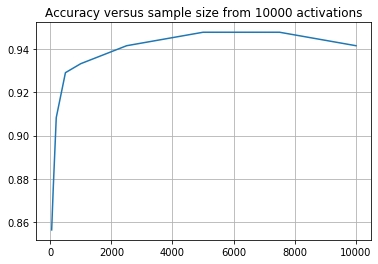

In [115]:
counts, accuracies = zip(*sorted(list(scores.items()), key = lambda x: x[0]))
plt.figure(facecolor = 'w')
plt.plot(counts, accuracies)
plt.grid()
plt.title('Accuracy versus sample size from 10000 activations')

In [ ]:
with open(os.path.join('..', 'neuron_logs', 'train_data', 'output_20191013-181903.json'), 'r') as f:
    neuron_data = json.load(f)
    

In [42]:
e = 5




Text(0.5, 1.0, "Distribution of some neuron's activations")

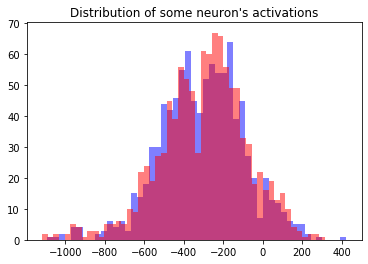

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
(0.9501336812973022, 3.954249677917687e-06)


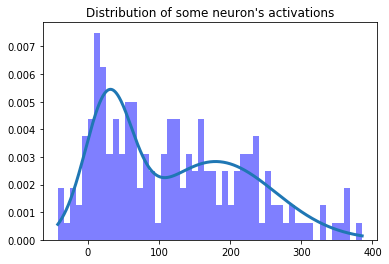

In [27]:
from sklearn.mixture import GaussianMixture


num = 6
neuron = '3 24'
current_data = neuron_data[str(e)][neuron]
some_data = reduce_to_statistics(current_data['activations'], neuron_data[str(e)]['original_labels'], debug=True) 
plt.hist(some_data[num], bins = 50, alpha = 0.5, color = 'blue', density=True)
#plt.hist(some_data[num-2], bins = 50, alpha = 0.5, color = 'red')
plt.title('Distribution of some neuron\'s activations')

gmm = GaussianMixture(n_components=2, verbose = 1)
gmm.fit(np.array(some_data[num]).reshape(-1, 1))
gmm.means_


# Plot the data to which the GMM is being fitted
x = np.linspace(min(some_data[num]), max(some_data[num]), 1000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

plt.plot(x, y, linewidth=3)

from scipy.stats import shapiro

print(shapiro(some_data[num][:2000]))

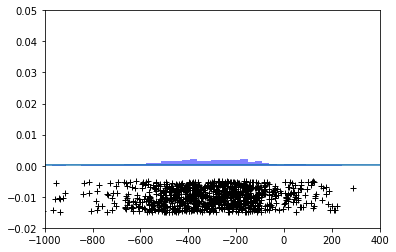

In [63]:
from scipy.stats import norm

np.random.seed(1)
X = np.array(some_data[num])[:, np.newaxis]

fig, ax = plt.subplots()


for kernel in ['gaussian']:
    kde = KernelDensity(kernel=kernel, bandwidth=1500).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-1000, 400)
ax.set_ylim(-0.02, 0.05)

ax.hist(some_data[num], bins = 50, alpha = 0.5, color = 'blue', density=True)

plt.show()

[[ 1.62434536]
 [-0.61175641]
 [-0.52817175]
 [-1.07296862]
 [ 0.86540763]
 [-2.3015387 ]
 [ 6.74481176]
 [ 4.2387931 ]
 [ 5.3190391 ]
 [ 4.75062962]
 [ 6.46210794]
 [ 2.93985929]
 [ 4.6775828 ]
 [ 4.61594565]
 [ 6.13376944]
 [ 3.90010873]
 [ 4.82757179]
 [ 4.12214158]
 [ 5.04221375]
 [ 5.58281521]]


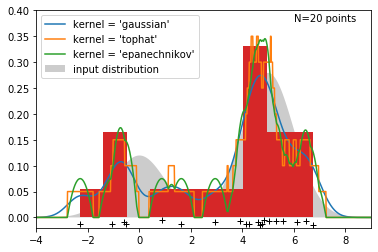

In [68]:

#----------------------------------------------------------------------
# Plot a 1D density example
N = 20
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

print(X)
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')
ax.hist(X, density=True)
ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()
